In [51]:
%pip install requests pandas tqdm folium

Note: you may need to restart the kernel to use updated packages.


In [52]:
import requests
import pandas as pd
from tqdm import tqdm
import folium

In [53]:
url_inventory_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
url_stations_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url_countries_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
url_states_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt"
url_state_raw = "https://raw.githubusercontent.com/georgique/world-geojson/develop/states/usa/new_hampshire.json"

In [54]:
def parse_stations_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEVATION": float(line[31:37].strip()),
                "STATE": line[38:40].strip(),
                "NAME": line[38:68].strip(),
            })
    return pd.DataFrame(data)

def parse_inventory_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEMENT": line[31:35].strip(),
                "FIRSTYEAR": int(line[36:40].strip()),
                "LASTYEAR": int(line[41:45].strip())
            })
    return pd.DataFrame(data)

def parse_countries_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:64].strip()
            })
    return pd.DataFrame(data)

def parse_states_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:50].strip()
            })
    return pd.DataFrame(data)

def parse_data_dly(line):
    data = []
    for i in range(21, 269, 8):
        value = int(line[i:i+5])
        mflag = line[i+5]
        qflag = line[i+6]
        sflag = line[i+7]
        data.extend([value, mflag, qflag, sflag])
    return {
        "ID": line[0:11].strip(),
        "YEAR": int(line[11:15]),
        "Month": int(line[15:17]),
        "ELEMENT": line[17:21].strip(),
        "DATA": data
    }

def read_data_from_url(url):
    data = []
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.splitlines():
            data.append(parse_data_dly(line))
    else:
        print(f"Failed to retrieve data for {url}. Status code: {response.status_code}")
    return data

def fetch_and_save_to_dataframe(station_ids):
    all_data = []
    for station_id in tqdm(station_ids, desc="Fetching Data", unit="station", ncols=100):
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly"
        data = read_data_from_url(url)
        all_data.extend(data)
    headers = ["ID", "YEAR", "Month", "ELEMENT"]
    for i in range(1, 32):
        headers.extend([f"VALUE{i}", f"MFLAG{i}", f"QFLAG{i}", f"SFLAG{i}"])
    df_data = []
    for entry in all_data:
        row = [entry["ID"], entry["YEAR"], entry["Month"], entry["ELEMENT"]]
        row.extend(entry["DATA"])
        df_data.append(row)
    return pd.DataFrame(df_data, columns=headers)


In [69]:
inventory = parse_inventory_txt(url_inventory_txt)
stations= parse_stations_txt(url_stations_txt)
countries = parse_countries_txt(url_countries_txt)
states = parse_states_txt(url_states_txt)

In [70]:
# For country
#s_country_list = stations[stations['ID'].str.startswith('US')]['ID'].tolist()
# For state
s_state_list=stations[stations['STATE']=='NH']['ID'].tolist()
s_live_list=inventory[(inventory['ID'].isin(s_state_list)) & (inventory['LASTYEAR']>=2024)]['ID'].unique().tolist()
result = inventory.loc[inventory['ID'].isin(s_live_list), ['ID', 'ELEMENT', 'FIRSTYEAR', 'LASTYEAR']]
result['YEAR_DIFF'] = result['LASTYEAR'] - result['FIRSTYEAR']
result_filtered = result[result['ELEMENT'].isin([ 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'PRCP'])]
Req_station_list = pd.Series(result_filtered[(result_filtered['YEAR_DIFF'] >= 75) & (result_filtered['LASTYEAR'] > 2024)]['ID'].tolist()).unique()

In [71]:
data= fetch_and_save_to_dataframe(Req_station_list)

Fetching Data: 100%|███████████████████████████████████████████| 19/19 [00:09<00:00,  2.10station/s]


In [72]:
flag_columns = [col for col in data.columns if 'FLAG' in col]
data= data.drop(columns=flag_columns)

In [59]:
def transform_weather_data(df):
    transformed_data = {}
    for index, row in df.iterrows():
        for day in range(1, 32):
            date = pd.to_datetime(f"{row['YEAR']}-{row['Month']:02d}-{day:02d}", errors='coerce')
            if pd.notna(date):
                if date not in transformed_data:
                    transformed_data[date] = {"ID": row['ID']}
                element = row['ELEMENT']
                value = row.get(f'VALUE{day}', None)
                if pd.notna(value) and value != -9999:
                    transformed_data[date][element] = value
    return pd.DataFrame.from_dict(transformed_data, orient='index').reset_index().rename(columns={'index': 'DATE'})

In [73]:
data.head(10)

,ID,YEAR,Month,ELEMENT,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,...,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,VALUE27,VALUE28,VALUE29,VALUE30,VALUE31
0,USC00270690,1886,6,TMAX,211,250,261,239,267,272,...,283,244,194,200,217,183,261,289,244,-9999
1,USC00270690,1886,6,TMIN,144,150,94,94,117,144,...,111,117,122,128,111,100,83,100,17,-9999
2,USC00270690,1886,6,PRCP,0,0,112,0,0,0,...,0,0,13,30,36,71,0,0,0,-9999
3,USC00270690,1886,6,WT08,-9999,-9999,-9999,-9999,-9999,-9999,...,1,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
4,USC00270690,1886,6,WT16,-9999,-9999,1,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999,-9999
5,USC00270690,1886,7,TMAX,250,300,322,322,328,322,...,217,200,278,261,244,244,278,300,300,278
6,USC00270690,1886,7,TMIN,22,44,89,117,117,128,...,111,50,50,61,139,150,111,111,144,83
7,USC00270690,1886,7,PRCP,0,0,0,0,0,0,...,0,5,0,0,0,76,0,0,0,0
8,USC00270690,1886,7,WT08,-9999,-9999,-9999,-9999,-9999,1,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
9,USC00270690,1886,7,WT16,-9999,-9999,-9999,-9999,-9999,-9999,...,1,-9999,-9999,-9999,-9999,-9999,1,-9999,1,-9999


In [74]:
import numpy as np
data.replace(-9999.0, np.nan, inplace=True)

In [75]:
weather_variables = ['TMAX', 'TMIN', 'SNOW', 'SNWD', 'PRCP', 'WT04', 'WT09', 'WT18']
data=data[data['ELEMENT'].isin(weather_variables)]

In [76]:
data.columns

Index(['ID', 'YEAR', 'Month', 'ELEMENT', 'VALUE1', 'VALUE2', 'VALUE3',
       'VALUE4', 'VALUE5', 'VALUE6', 'VALUE7', 'VALUE8', 'VALUE9', 'VALUE10',
       'VALUE11', 'VALUE12', 'VALUE13', 'VALUE14', 'VALUE15', 'VALUE16',
       'VALUE17', 'VALUE18', 'VALUE19', 'VALUE20', 'VALUE21', 'VALUE22',
       'VALUE23', 'VALUE24', 'VALUE25', 'VALUE26', 'VALUE27', 'VALUE28',
       'VALUE29', 'VALUE30', 'VALUE31'],
      dtype='object')

In [79]:
from collections import defaultdict

# Group by 'ID', 'YEAR', and 'Month'
station_year_month = data.groupby(['ID', 'YEAR', 'Month']).size().reset_index(name='count')

# Create a dictionary to store missing year-month pairs by station
missing_by_station = defaultdict(list)

# Iterate over each station
for station in data['ID'].unique():
    # Get the min and max year for the current station
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()

    # Identify all possible Year-Month combinations for this station
    all_years = range(min_year, max_year)  # Adjust to start from the station's min year
    all_months = range(1, 13)

    # Create a DataFrame with all possible combinations for the station
    all_combinations = pd.MultiIndex.from_product([all_years, all_months], names=['YEAR', 'Month'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()

    # Filter data for the current station
    station_data = station_year_month[station_year_month['ID'] == station]

    # Merge the actual data with the full combinations
    merged_data = pd.merge(all_combinations_df, station_data, on=['YEAR', 'Month'], how='left')
    
    # Filter to show missing combinations (where count is NaN)
    missing_data = merged_data[merged_data['count'].isna()]

    # Collect missing year-month pairs for this station
    missing_pairs = missing_data[['YEAR', 'Month']].itertuples(index=False, name=None)
    
    # Group missing pairs by station
    for pair in missing_pairs:
        missing_by_station[station].append((pair[0], pair[1]))

# Display missing years and then missing year-month pairs
for station, pairs in missing_by_station.items():
    # Get the min and max years for the station
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()

    # Identify years that are missing for all months
    years_missing = set([year for year, _ in pairs])  # Get all unique missing years for the station
    months_missing = set([month for _, month in pairs])  # Get all unique missing months for the station
    
    fully_missing_years = [year for year in years_missing if len(months_missing) == 12]
    
    # Print station start and end year
    print(f"For station {station} (Years: {min_year} to {max_year}):")

    # Display missing years first
    if fully_missing_years:
        print(f"  These years are missing for all months: {sorted(fully_missing_years)}")
    
    # Exclude the fully missing years and display the missing year-month pairs
    remaining_pairs = [(year, month) for year, month in pairs if year not in fully_missing_years]
    
    if remaining_pairs:
        print(f"  These are the missing year-month pairs:")
        for year, month in sorted(remaining_pairs):  # Sort the remaining year-month pairs
            print(f"    Year: {year}, Month: {month}")
        print()  # Add a blank line for readability


For station USC00270690 (Years: 1886 to 2025):
  These years are missing for all months: [1886, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1948, 1969, 1970, 1973, 1974]
For station USC00272999 (Years: 1918 to 2025):
  These years are missing for all months: [1925, 1926, 1927, 1928, 1929, 1973]
For station USC00273182 (Years: 1948 to 2025):
  These years are missing for all months: [1948, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
For station USC00273850 (Years: 1884 to 2025):
  These are the missing year-month pairs:
    Year: 1884, Month: 1
    Year: 1884, Month: 2
    Year: 1884, Month: 3
    Year: 1884, Month: 4
    Year: 1884, Month: 5
    Year: 1884, Month: 6
    Year: 1884, Month: 7
    Year: 1884, Month: 8
    Year: 1884, Month: 9
    Year: 1884, Month: 10
    Year: 1892, Month: 4
    Y

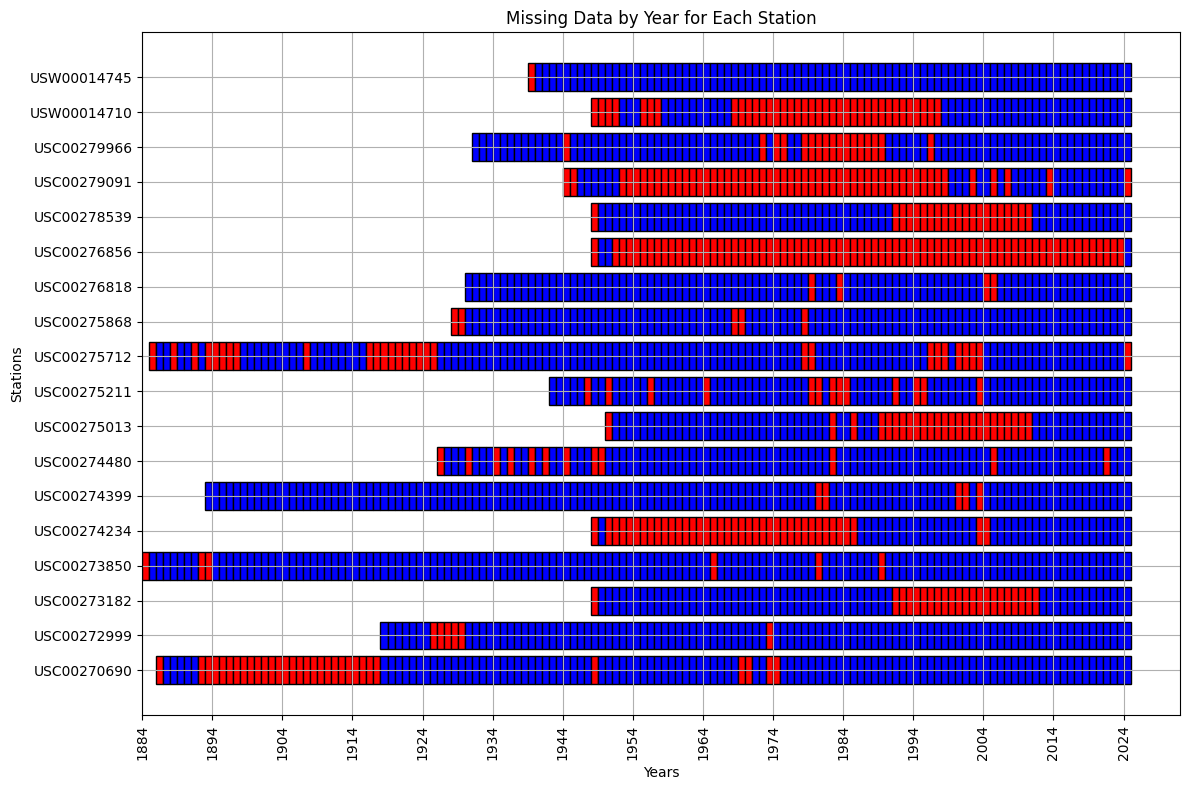

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create a color map for missing data and available data
missing_color = 'red'
available_color = 'blue'

# Find the overall min and max year across all stations
min_overall_year = min([data[data['ID'] == station]['YEAR'].min() for station in data['ID'].unique()])
max_overall_year = max([data[data['ID'] == station]['YEAR'].max() for station in data['ID'].unique()])

# Loop over each station to create the plot
for idx, (station, pairs) in enumerate(missing_by_station.items()):
    # Get the min and max years for the station
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()

    # Generate a 2D grid for years (x-axis) and months (y-axis)
    years = np.arange(min_year, max_year)

    # Initialize a matrix to represent data availability (1 for missing data, 0 for available data)
    availability_matrix = np.zeros(len(years))

    # Mark missing year-month pairs
    for year, _ in pairs:
        year_idx = np.where(years == year)[0][0]
        availability_matrix[year_idx] = 1  # Mark missing data as 1

    # Create bars for each year, marking missing data in red and available data in blue
    for i, year in enumerate(years):
        if availability_matrix[i] == 1:
            ax.barh(idx, 1, left=year, height=0.8, color=missing_color, edgecolor='black')
        else:
            ax.barh(idx, 1, left=year, height=0.8, color=available_color, edgecolor='black')

# Set labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Stations')
ax.set_title('Missing Data by Year for Each Station')

# Customize year labels on x-axis: show first, last, and every 10th year
x_ticks = [min_overall_year] + list(range(min_overall_year + 10, max_overall_year, 10)) 
ax.set_xticks(x_ticks)

# Customize station names on y-axis
ax.set_yticks(np.arange(len(missing_by_station)))
ax.set_yticklabels(list(missing_by_station.keys()))

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Add grid
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [81]:
data.tail(10)

,ID,YEAR,Month,ELEMENT,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,...,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,VALUE27,VALUE28,VALUE29,VALUE30,VALUE31
133898,USW00014755,2025,1,TMAX,-11.0,-17.0,-128.0,-233.0,-222.0,-100.0,...,-250.0,-200.0,-161.0,-194.0,-150.0,-139.0,-122.0,-133.0,-106.0,-100.0
133899,USW00014755,2025,1,TMIN,-72.0,-139.0,-178.0,-233.0,-239.0,-139.0,...,-278.0,-272.0,-206.0,-244.0,-233.0,-178.0,-178.0,-261.0,-294.0,-300.0
133901,USW00014755,2025,1,PRCP,33.0,173.0,102.0,0.0,15.0,5.0,...,0.0,8.0,0.0,0.0,13.0,36.0,23.0,43.0,46.0,8.0
133902,USW00014755,2025,1,SNOW,20.0,122.0,94.0,5.0,28.0,5.0,...,3.0,15.0,0.0,0.0,15.0,43.0,30.0,64.0,46.0,15.0
133903,USW00014755,2025,1,SNWD,51.0,51.0,76.0,76.0,76.0,76.0,...,152.0,152.0,127.0,127.0,127.0,102.0,102.0,127.0,127.0,127.0
133905,USW00014755,2025,2,TMAX,-67.0,-172.0,-117.0,-39.0,-161.0,-117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133906,USW00014755,2025,2,TMIN,-178.0,-250.0,-183.0,-172.0,-261.0,-250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133908,USW00014755,2025,2,PRCP,46.0,5.0,20.0,124.0,30.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133909,USW00014755,2025,2,SNOW,76.0,8.0,56.0,99.0,33.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133910,USW00014755,2025,2,SNWD,178.0,152.0,178.0,203.0,178.0,178.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
state_stations = stations[stations['STATE']=='NH']
state_lat = state_stations['LATITUDE'].mean()
state_lon = state_stations['LONGITUDE'].mean()
state_map = folium.Map(location=[state_lat, state_lon], 
                       zoom_start=7.5,
                       min_zoom=6,
                       max_zoom=10)

stations_to_plot = stations[stations['ID'].isin(Req_station_list)]
for _, row in stations_to_plot.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['NAME'],
        tooltip=row['NAME']
    ).add_to(state_map)
try:
    geojson_data = requests.get(url_state_raw).json() 
    folium.GeoJson(geojson_data, name="State Boundary").add_to(state_map)
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    
state_map

In [17]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to the 'month' column
data['season'] = data['Month'].apply(get_season)

# Now you can split the data by season
winter_data = data[data['season'] == 'Winter']
spring_data = data[data['season'] == 'Spring']
summer_data = data[data['season'] == 'Summer']
fall_data = data[data['season'] == 'Fall']

In [29]:
wd= transform_weather_data(winter_data)

In [31]:
winter_data.head(5)

,ID,YEAR,Month,ELEMENT,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,...,VALUE23,VALUE24,VALUE25,VALUE26,VALUE27,VALUE28,VALUE29,VALUE30,VALUE31,season
27,USC00270690,1886,12,TMAX,-11,-11,-67,-11,-122,-78,...,50,94,-11,44,-39,-50,22,-78,-11,Winter
28,USC00270690,1886,12,TMIN,-111,-183,-189,-111,-317,-222,...,-33,-28,-217,-211,-189,-217,-250,-300,-294,Winter
29,USC00270690,1886,12,PRCP,8,86,0,0,0,0,...,0,318,0,48,0,0,0,0,0,Winter
30,USC00270690,1886,12,SNOW,-9999,107,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,64,-9999,-9999,-9999,-9999,-9999,Winter
31,USC00270690,1886,12,WT18,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999,-9999,Winter


In [32]:
wd.head(10)

,DATE,ID,TMAX,TMIN,PRCP,SNOW,SNWD,WT18,WT08,WT01,...,DAPR,MDPR,WT14,WT03,WT07,WT06,DASF,MDSF,WT09,WESD
0,1886-12-01,USC00270690,83.0,11.0,28.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1886-12-02,USC00270690,17.0,-72.0,5.0,13.0,76.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1886-12-03,USC00270690,-56.0,-122.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1886-12-04,USC00270690,-56.0,-128.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1886-12-05,USC00270690,-89.0,-156.0,79.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1886-12-06,USC00270690,-28.0,-122.0,211.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1886-12-07,USC00270690,-28.0,-122.0,566.0,160.0,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1886-12-08,USC00270690,6.0,-106.0,0.0,267.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1886-12-09,USC00270690,44.0,-22.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1886-12-10,USC00270690,44.0,-156.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
wd['DATE'] = pd.to_datetime(wd['DATE'], errors='coerce')

# Extract month and day from the date column
wd['Month'] = wd['DATE'].dt.month
wd['Day'] = wd['DATE'].dt.day

In [22]:
import pandas as pd

# Ensure DATE column is in datetime format
wd['DATE'] = pd.to_datetime(wd['DATE'])

# Identify missing winter dates directly from wd which already contains only winter months
date_range_winter = pd.date_range(start=wd['DATE'].min(), end=wd['DATE'].max(), freq='D')

# Filter only winter months from the generated range
winter_dates = date_range_winter[date_range_winter.month.isin([12, 1, 2])]

# Identify missing dates by comparing existing dates with the full winter range
missing_dates = sorted(set(winter_dates) - set(wd['DATE']))

print("Missing winter dates in the dataset:")
print(missing_dates)



Missing winter dates in the dataset:
[]


In [23]:
wd.shape

(12724, 27)

In [24]:
wd.head(91)

,DATE,ID,TMAX,TMIN,PRCP,SNOW,WT18,SNWD,WT01,WT08,...,WT14,WT03,WT07,WT06,DASF,MDSF,WT09,WESD,Month,Day
0,1886-12-01,USC00270690,83.0,11.0,28,0.0,-9999.0,-9999.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1
1,1886-12-02,USC00270690,17.0,-72.0,5,13.0,-9999.0,76.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2
2,1886-12-03,USC00270690,-56.0,-122.0,0,0.0,-9999.0,-9999.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,3
3,1886-12-04,USC00270690,-56.0,-128.0,0,0.0,-9999.0,-9999.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,4
4,1886-12-05,USC00270690,-89.0,-156.0,79,-9999.0,-9999.0,-9999.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1887-02-25,USC00270690,28.0,-117.0,0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,25
87,1887-02-26,USC00270690,-44.0,-172.0,132,76.0,-9999.0,76.0,-9999.0,-9999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,26
88,1887-02-27,USC00270690,39.0,-56.0,351,89.0,1.0,-9999.0,-9999.0,-9999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,27
89,1887-02-28,USC00270690,-28.0,-117.0,0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,28


In [26]:

import numpy as np

# Alternatively, you can use rolling mean:
wd['TMAX'] = wd['TMAX'].rolling(window=7, min_periods=1).mean()  # 7-day rolling mean
wd['TMIN'] = wd['TMIN'].rolling(window=7, min_periods=1).mean()  # 7-day rolling mean

# 2. Precipitation (PRCP) and Snowfall (SNOW, SNWD) - Forward Fill, Backward Fill, or Monthly Mean
wd['PRCP'] = wd['PRCP'].fillna(0)  # Fill missing values with 0 (assuming no precipitation means zero)
wd['SNOW'] = wd['SNOW'].fillna(0)  # Same for Snowfall
wd['SNWD'] = wd['SNWD'].fillna(wd['SNWD'].mean())  # Use the mean of SNWD to fill missing values

# Display the updated DataFrame
print(wd)


DataError: No numeric types to aggregate

In [ ]:
relevant_columns = ['DATE','ID','TMAX', 'TMIN','SNOW', 'SNWD', 'PRCP',  'WT04', 'WT09', 'WT18']
wd = wd[relevant_columns]


In [ ]:
wd.describe()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = wd[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Elements')
plt.show()


In [ ]:
print(correlation_matrix)

In [ ]:
# Example of accessing the split data
winter_data[(winter_data['YEAR'] == 2024 ) & (winter_data['Month']==2)].head(20)

In [ ]:
# Group by 'station' and 'element', then count occurrences of each element per station
element_counts_by_station = data.groupby(['ID', 'ELEMENT']).size().unstack(fill_value=0)

# Print the result
element_counts_by_station[['SNOW', 'SNWD', 'WESD', 'PRCP', 'TMAX', 'TMIN']].sum(axis=1).sort_values(ascending=False).head(10)

# Individual counts for each element
element_counts_by_station[['SNOW', 'SNWD', 'WESD', 'PRCP', 'TMAX', 'TMIN']]




In [ ]:
# Remove duplicates
data_unique = data.drop_duplicates(subset=['ID', 'YEAR', 'Month'])

# Group by 'ID' and count the number of rows for each station
rows_per_station = data_unique.groupby('ID').size()

print(rows_per_station)